In [4]:
import glob
import os
import importlib
import sys
from grandprix import Sim
import numpy as np
import matplotlib.pyplot as plt

def race(seed, race_name):
    home=os.environ['HOME']
    path=os.path.join(home, "Downloads/grandprix")
    sys.path.insert(0, path)
    os.chdir(path)

    results = []
    data = {}
    for f in glob.glob("*.py"):
        mod_name = f.split('.')[0]
        np.random.seed(seed)
        mod = importlib.import_module(mod_name)
        sim = Sim(mod.Controller)
        dist = sim.run()
        name = f.split('_')[1]
        results.append({
            'name': name,
            'dist': dist})
        data[name] = sim.data

    results = sorted(results, key=lambda x: x['dist'], reverse=True)

    place = 1
    j = 0
    while j < len(results):
        tie_count = 1
        i = 0
        while j + i + 1 < len(results):
            if results[j + i]['dist'] == results[j + i  + 1]['dist']:
                tie_count += 1
                i += 1
            else:
                break
        if tie_count > 1:
            for i in range(tie_count):
                results[j + i]['place'] = int(place + tie_count/2)
            j += tie_count
            place += tie_count
        else:
            results[j]['place'] = place
            place += 1
            j += 1

    n = len(results)
    for r in results:
        if r['place'] <= 0.25*n:
            r['points'] = 4
        elif r['place'] <= 0.5*n:
            r['points'] = 3
        elif r['place'] <= 0.75*n:
            r['points'] = 2
        else:
            r['points'] = 1

    with open('grandprix_{:s}.txt'.format(race_name), 'w') as f:
        for r in results:
            f.write("place: {:4d}\tpoints: {:4d}"
                    "\tname: {:15s}\tdistance: {:10.3f} m\n".format(
                r['place'], r['points'], r['name'], r['dist']))

    with open('grandprix_anon_{:s}.txt'.format(race_name), 'w') as f:
        for r in results:
            f.write("place: {:4d}\tpoints: {:4d}"
                    "\tdistance: {:10.3f} m\n".format(
                r['place'], r['points'], r['dist']))

    plt.figure(figsize=(10, 10))
    d = data[results[0]['name']]
    plt.plot(d['track_left_x'], d['track_left_y'], 'k', linewidth=1)
    plt.plot(d['track_right_x'], d['track_right_y'], 'k', linewidth=1)
    plt.grid()
    for i in range(len(results)):
        d = data[results[i]['name']]
        plt.plot(d['x'], d['y'], linewidth=3)
    plt.title('Grand Prix {:s}'.format(race_name))
    plt.xlabel('x, m')
    plt.ylabel('y, m')
    plt.savefig('{:s}.png'.format(race_name))

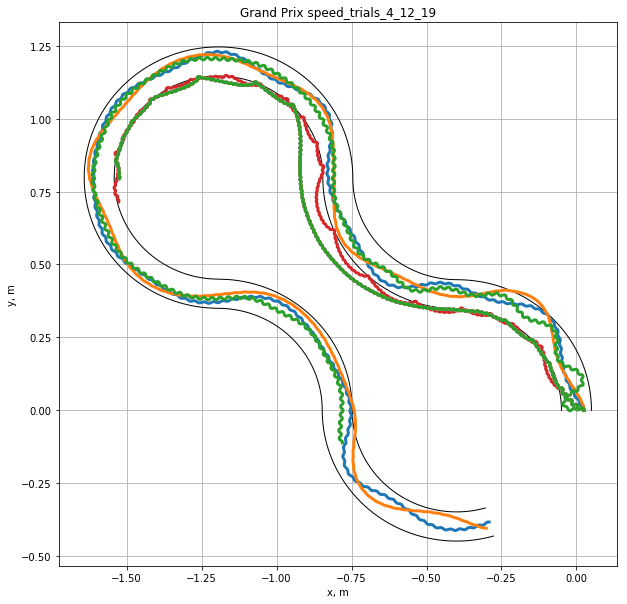

In [5]:
race(2143, 'speed_trials_4_12_19')

In [6]:
!cat /home/jgoppert/Downloads/grandprix/grandprix_anon_speed_trials_4_12_19.txt

place:    1	points:    4	distance:      4.433 m
place:    2	points:    4	distance:      4.423 m
place:    3	points:    4	distance:      3.810 m
place:    4	points:    3	distance:      2.552 m
place:    9	points:    2	distance:      2.457 m
place:    9	points:    2	distance:      2.457 m
place:    9	points:    2	distance:      2.457 m
place:    9	points:    2	distance:      2.457 m
place:    9	points:    2	distance:      2.457 m
place:    9	points:    2	distance:      2.457 m
place:    9	points:    2	distance:      2.457 m
place:    9	points:    2	distance:      2.457 m
place:    9	points:    2	distance:      2.457 m
